In [240]:
%pylab inline

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import make_scorer, r2_score


from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.text import one_hot
from keras.wrappers.scikit_learn import KerasClassifier

from IPython.display import display

Populating the interactive namespace from numpy and matplotlib


## Data

In [167]:
raw_data = pd.read_csv('../../data/insurance/insurance.csv')

# Preprocessing
bmi_scaler = StandardScaler()
raw_data[['bmi']] = bmi_scaler.fit_transform(raw_data[['bmi']].values)
raw_data['sex'] = raw_data['sex'].apply({'male': 1, 'female': 0}.get)
raw_data['smoker'] = raw_data['smoker'].apply({'yes': 1, 'no': 0}.get)

# Region
onehot_smokers = pd.get_dummies(raw_data['region'], prefix='region')
raw_data = pd.concat([raw_data, onehot_smokers], axis=1)
# raw_data = raw_data.drop('region', axis=1)

# Y Labels
expense_scaler = StandardScaler()
raw_data['expenses'] = expense_scaler.fit_transform(raw_data[['expenses']].values)
data_y = raw_data.as_matrix(['expenses'])


# X Labels
data_x = raw_data.drop(['expenses', 'region'], axis=1)
display(data_x.describe())
data_x = data_x.as_matrix()

# Split data into train and test subset
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.3)

print('[TRAIN]')
print('train_x:', train_x.shape)
print('train_y:', train_y.shape)
print('\n[TEST]')
print('test_x:', test_x.shape)
print('test_y:', test_y.shape)

,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
count,1338.000000,1338.000000,1.338000e+03,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.505232,-4.089073e-16,1.094918,0.204783,0.242152,0.242900,0.272048,0.242900
std,14.049960,0.500160,1.000374e+00,1.205493,0.403694,0.428546,0.428995,0.445181,0.428995
min,18.000000,0.000000,-2.405713e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,0.000000,-7.161085e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.000000,1.000000,-4.354763e-02,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,51.000000,1.000000,6.618210e-01,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,64.000000,1.000000,3.680143e+00,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000


[TRAIN]
train_x: (936, 9)
train_y: (936, 1)

[TEST]
test_x: (402, 9)
test_y: (402, 1)


## Model

In [311]:
def create_model(l1_out=18, l2_out=12, l3_out=6):
    model = Sequential()
    model.add(Dense(l1_out, batch_input_shape=(None, 9), activation='sigmoid', name='layer01'))
    model.add(Dense(l2_out, activation='sigmoid', name='layer02'))
    model.add(Dense(l3_out, activation='sigmoid', name='layer03'))
    model.add(Dense(1, name='layer04'))
    model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

## Hyperparameter Optimization

In [312]:
def accuracy(y_true, y_pred):
    loss = mean_squared_error(y_true, y_pred)
    score = r2_score(y_true, y_pred)
    print(f'score:{score:.6}\tloss:{loss:.6}')
    return score

params = dict(l1_out= [32, 16],
              l2_out= [32, 16],
              l3_out= [16, 9], 
              epochs= [300])

classifier = KerasClassifier(create_model, verbose=0)
scorer = make_scorer(accuracy, greater_is_better=False)
grid = GridSearchCV(classifier, param_grid=params, scoring=scorer)
grid_result = grid.fit(data_x, data_y)

score:0.444859	loss:0.564896
score:0.430947	loss:0.56372
score:0.386222	loss:0.59798
score:0.432528	loss:0.573927
score:0.443964	loss:0.558879
score:0.437988	loss:0.560458
score:0.445455	loss:0.564289
score:0.43061	loss:0.564054
score:0.423935	loss:0.561238
score:0.447112	loss:0.559177
score:0.438816	loss:0.564053
score:0.439086	loss:0.559363
score:0.448216	loss:0.561479
score:0.432883	loss:0.561802
score:0.424647	loss:0.560544
score:0.446883	loss:0.559408
score:0.444139	loss:0.558703
score:0.439077	loss:0.559372
score:0.449159	loss:0.560521
score:0.43399	loss:0.560706
score:0.421444	loss:0.563665
score:0.449178	loss:0.557087
score:0.438366	loss:0.564506
score:0.439272	loss:0.559177
score:0.44599	loss:0.563745
score:0.429498	loss:0.565156
score:0.424647	loss:0.560544
score:0.446503	loss:0.559792
score:0.43816	loss:0.564712
score:0.436888	loss:0.561555
score:0.447092	loss:0.562624
score:0.430281	loss:0.56438
score:0.419096	loss:0.565952
score:0.445194	loss:0.561116
score:0.444139	loss:0

In [313]:
_mean_scores = grid_result.cv_results_['mean_test_score']
_stds = grid_result.cv_results_['std_test_score']
_params = grid_result.cv_results_['params']

print('Best:', grid_result.best_params_)

results = [(mean, std, param) for mean, std, param in zip(_mean_scores, _stds, _params)]
results = sorted(results, key=lambda x: -x[1])

for mean, std, param in results:
    print(f'Mean Score:{mean:.7},\tSTD Score:{std:.5},\tParams: {param}')

Best: {'epochs': 300, 'l1_out': 32, 'l2_out': 32, 'l3_out': 16}
Mean Score:-0.4250149,	STD Score:0.027433,	Params: {'epochs': 300, 'l1_out': 32, 'l2_out': 32, 'l3_out': 16}
Mean Score:-0.4310385,	STD Score:0.017693,	Params: {'epochs': 300, 'l1_out': 16, 'l2_out': 16, 'l3_out': 16}
Mean Score:-0.4367754,	STD Score:0.012559,	Params: {'epochs': 300, 'l1_out': 16, 'l2_out': 32, 'l3_out': 9}
Mean Score:-0.4363227,	STD Score:0.011406,	Params: {'epochs': 300, 'l1_out': 32, 'l2_out': 16, 'l3_out': 9}
Mean Score:-0.4358766,	STD Score:0.010899,	Params: {'epochs': 300, 'l1_out': 16, 'l2_out': 16, 'l3_out': 9}
Mean Score:-0.4390007,	STD Score:0.010285,	Params: {'epochs': 300, 'l1_out': 32, 'l2_out': 16, 'l3_out': 16}
Mean Score:-0.4360688,	STD Score:0.0089978,	Params: {'epochs': 300, 'l1_out': 32, 'l2_out': 32, 'l3_out': 9}
Mean Score:-0.4362659,	STD Score:0.0088158,	Params: {'epochs': 300, 'l1_out': 16, 'l2_out': 32, 'l3_out': 16}


## Training

In [314]:
model = create_model(32, 32, 16)
model.fit(data_x, data_y, epochs=300, verbose=2)

Epoch 1/300
2s - loss: 1.0052 - mean_squared_error: 1.0052
Epoch 2/300
0s - loss: 0.9864 - mean_squared_error: 0.9864
Epoch 3/300
0s - loss: 0.9793 - mean_squared_error: 0.9793
Epoch 4/300
0s - loss: 0.9572 - mean_squared_error: 0.9572
Epoch 5/300
0s - loss: 0.9232 - mean_squared_error: 0.9232
Epoch 6/300
0s - loss: 0.8821 - mean_squared_error: 0.8821
Epoch 7/300
0s - loss: 0.8309 - mean_squared_error: 0.8309
Epoch 8/300
0s - loss: 0.7716 - mean_squared_error: 0.7716
Epoch 9/300
0s - loss: 0.7076 - mean_squared_error: 0.7076
Epoch 10/300
0s - loss: 0.6270 - mean_squared_error: 0.6270
Epoch 11/300
0s - loss: 0.5428 - mean_squared_error: 0.5428
Epoch 12/300
0s - loss: 0.4565 - mean_squared_error: 0.4565
Epoch 13/300
0s - loss: 0.3705 - mean_squared_error: 0.3705
Epoch 14/300
0s - loss: 0.3112 - mean_squared_error: 0.3112
Epoch 15/300
0s - loss: 0.2803 - mean_squared_error: 0.2803
Epoch 16/300
0s - loss: 0.2656 - mean_squared_error: 0.2656
Epoch 17/300
0s - loss: 0.2546 - mean_squared_err

Accuracy (R Score): 0.852819424447


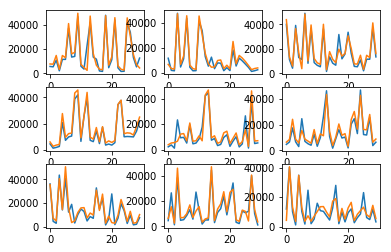

In [309]:
y_pred = model.predict(test_x)
y_pred = expense_scaler.inverse_transform(y_pred)
y_true = expense_scaler.inverse_transform(test_y)

print('Accuracy (R Score):', r2_score(y_true, y_pred))

fg, _plots = subplots(3, 3)
N = len(y_pred)
rng = 30

for p in _plots.flatten():
    idx = np.random.randint(0, N-rng)
    
    p.plot(y_true[idx:idx+rng])
    p.plot(y_pred[idx:idx+rng])

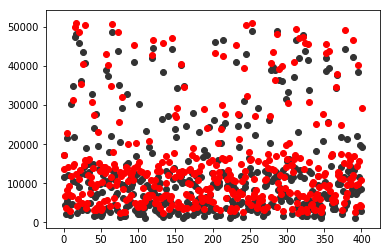

In [310]:
y_pred = model.predict(test_x)
y_pred = expense_scaler.inverse_transform(y_pred)
y_true = expense_scaler.inverse_transform(test_y)
N = len(y_pred)
x = list(range(N))
scatter(x, y_true, color='#333333', label='y_true')
scatter(x, y_pred, color='red', label='y_pred')
grid()
legend()